# Assignment 1: Exploratory Visual Analysis
#### Aya Migdadi, Aya Hmedat

## Load 2011 Stop & Frisk Dataset

In [1]:
# Import Statements
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Load the comma delimited data file
path = "2011.csv"
initial_data = pd.read_csv(path, encoding='latin-1', low_memory=False) 
initial_data.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,2011,102,185,1012011,0,A,O,P,1,BURGLARY,...,,102,B,,,1030708,194185,CM,1,14
1,2011,115,50,1012011,5,A,O,P,1,FEL,...,,115,I,,,1021302,213563,CM,1,85
2,2011,100,4,1012011,7,1,O,H,1,CPW,...,,100,B,4,34,1037668,153549,CM,1,20
3,2011,100,3,1012011,7,1,O,H,1,CPW,...,,100,B,4,34,1037668,153549,CM,1,20
4,2011,100,1,1012011,7,1,O,H,1,CPW,...,,100,B,4,34,1037668,153549,CM,1,20


array([<AxesSubplot:ylabel='arstmade'>], dtype=object)

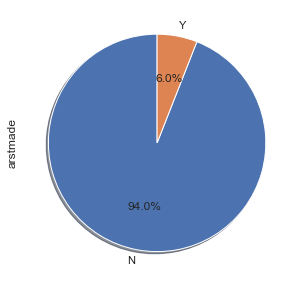

In [4]:
initial_data['arstmade'].value_counts().plot(kind='pie', subplots=True, shadow = True,startangle=90,
figsize=(8,5), autopct='%1.1f%%')

In [5]:
# Check size of dataset
initial_data.shape

(685724, 112)

In [6]:
# Check for presence of duplicate rows before filtering to relevant features
initial_data[initial_data.duplicated()].shape

(0, 112)

## Data Preprocessing

Cleaning the data and prepping it

In [7]:
# Extract relevant features (predictor and response) that will be utilized for analysis and remove those that will result in data leakage
# Precint (pct) is retained to clean city feature, but will be removed later on due to difficulty in binning them into separate pricints

# snf_data_pre = 'stop and frisk' data before preliminary processing
# Predictor features include description of suspect, officer behaviour and circumstances of the stop
# Response feature is whether the suspect was frisked
snf_data_pre = initial_data[['sex','race','age','ht_feet','ht_inch','weight','haircolr','eyecolor','build',
                            'city','pct','timestop','inout','trhsloc','typeofid','othpers',
                            'explnstp','offunif','officrid','offverb','offshld',
                            'ac_rept','ac_proxm','ac_evasv','ac_assoc','ac_cgdir','ac_incid','ac_time','ac_stsnd',
                            'frisked','arstmade']].copy()

In [8]:
# Numeric features
snf_data_pre.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,685724.0,29.398764,37.221556,0.0,19.0,24.0,34.0,999.0
ht_feet,685724.0,5.179049,0.394506,3.0,5.0,5.0,5.0,7.0
ht_inch,685724.0,6.415804,3.342623,0.0,4.0,7.0,9.0,11.0
weight,685724.0,169.323824,37.683693,0.0,150.0,165.0,180.0,999.0
pct,685724.0,67.375982,32.736376,1.0,42.0,71.0,101.0,123.0
timestop,685724.0,1435.877044,727.141924,0.0,1034.0,1630.0,2028.0,2359.0


In [9]:
### Calculate total height of individuals in inches by combining ht_feet and ht_inch

# Create new column combining feet and inches into one number
snf_data_pre['ht_inch'] = (snf_data_pre['ht_feet'] * 12) + snf_data_pre['ht_inch']

# Delete feet column 
del snf_data_pre['ht_feet']

# Rename ht_inch to height
snf_data_pre.rename(columns={'ht_inch': 'height'}, inplace=True)

snf_data_pre.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,685724.0,29.398764,37.221556,0.0,19.0,24.0,34.0,999.0
height,685724.0,68.564389,3.181265,36.0,67.0,69.0,71.0,95.0
weight,685724.0,169.323824,37.683693,0.0,150.0,165.0,180.0,999.0
pct,685724.0,67.375982,32.736376,1.0,42.0,71.0,101.0,123.0
timestop,685724.0,1435.877044,727.141924,0.0,1034.0,1630.0,2028.0,2359.0


In [10]:
# Get data types
snf_data_pre.dtypes

sex         object
race        object
age          int64
height       int64
weight       int64
haircolr    object
eyecolor    object
build       object
city        object
pct          int64
timestop     int64
inout       object
trhsloc     object
typeofid    object
othpers     object
explnstp    object
offunif     object
officrid    object
offverb     object
offshld     object
ac_rept     object
ac_proxm    object
ac_evasv    object
ac_assoc    object
ac_cgdir    object
ac_incid    object
ac_time     object
ac_stsnd    object
frisked     object
arstmade    object
dtype: object

In [11]:
snf_data_pre.drop('frisked',axis='columns',inplace=True)

In [12]:
# Get list of column names which are of type string (categorical) 
str_cols = snf_data_pre.select_dtypes(['object']).columns
str_cols

Index(['sex', 'race', 'haircolr', 'eyecolor', 'build', 'city', 'inout',
       'trhsloc', 'typeofid', 'othpers', 'explnstp', 'offunif', 'officrid',
       'offverb', 'offshld', 'ac_rept', 'ac_proxm', 'ac_evasv', 'ac_assoc',
       'ac_cgdir', 'ac_incid', 'ac_time', 'ac_stsnd', 'arstmade'],
      dtype='object')

In [13]:
# String features 
snf_data_pre[str_cols].describe()
# There are a number of features with missing values (city, officrid, offverb, offshld)

,sex,race,haircolr,eyecolor,build,city,inout,trhsloc,typeofid,othpers,...,offshld,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,arstmade
count,685724,685724,685724,685724,685724,685724,685724,685724,685724,685724,...,685724,685724,685724,685724,685724,685724,685724,685724,685724,685724
unique,3,8,11,13,5,6,2,3,4,2,...,2,2,2,2,2,2,2,2,2,2
top,M,B,BK,BR,M,BROOKLYN,O,P,P,N,...,,N,N,N,N,N,Y,N,N,N
freq,626830,350743,519671,615932,402968,228324,545779,544854,368749,537590,...,512650,607202,539509,553879,657165,519347,407523,398181,668900,644841


### Handling missing values

In [14]:
# Create deep copy of dataframe in case there's need to revert to original dataframe
snf_data_toclean = snf_data_pre.copy()
snf_data_toclean.shape

(685724, 29)

In [15]:
# Replace empty values of parameters with Nan
snf_data_toclean.replace(to_replace=' ', value=np.NaN, inplace=True)

In [16]:
# Count number of empty values
snf_data_toclean.isnull().sum()

sex              0
race             0
age              0
height           0
weight           0
haircolr         0
eyecolor         0
build            0
city            38
pct              0
timestop         0
inout            0
trhsloc          0
typeofid         0
othpers          0
explnstp         0
offunif          0
officrid    677711
offverb     548624
offshld     512650
ac_rept          0
ac_proxm         0
ac_evasv         0
ac_assoc         0
ac_cgdir         0
ac_incid         0
ac_time          0
ac_stsnd         0
arstmade         0
dtype: int64

Each precint has a corresponding city (a city can have multiple precints). Hence, the missing city values can be imputed using their corresponding precint. 

Reference: [New York City Precint Information](https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page)

In [17]:
# View pct (precints) of missing city data
snf_data_toclean.loc[snf_data_toclean['city'].isnull()]['pct'].unique()

array([ 18,  23,  33,  34,  70,  73,  75,  77,  79,  88, 115, 120],
      dtype=int64)

In [18]:
# Impute missing city values using precint data

for i in [1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='MANHATTAN'

for i in [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='BRONX'

for i in [60,61,62,63,66,67,68,69,70,71,72,73,75,76,77,78,79,81,83,84,88,90,94]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='BROOKLYN'

for i in [100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='QUEENS'

for i in [120,121,122,123]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='STATEN IS'

In [19]:
# Check all city values have been imputed correctly (no null values)
snf_data_toclean.isnull().sum()['city']

0

In [20]:
# Drop precint column as no longer needed
snf_data_toclean.drop(labels='pct', axis=1, inplace=True)

# Check if pct removed
'pct' in snf_data_toclean 

False

In [21]:
# View quantity of unique values in officrid, offverb and offshld  
print(snf_data_toclean['officrid'].value_counts())
print(snf_data_toclean['offverb'].value_counts())
print(snf_data_toclean['offshld'].value_counts())

I    8013
Name: officrid, dtype: int64
V    137100
Name: offverb, dtype: int64
S    173074
Name: offshld, dtype: int64


Based on the dataset's documentation, the values of these features: 
* officrid (officer provided id)
* offverb (officer gave verbal statement)
* offshld (officer showed badge) 

are either a letter (meaning Yes), zero (No) or empty (not listed). 

As there isn't sufficient information to impute them, and deleting rows with missing values would result in loss of large portion of dataset, these columns will be dropped.


In [22]:
# Print shape of dataframe before dropping columns
print(snf_data_toclean.shape)
# Drop the 3 columns 
snf_data_toclean.drop(labels=['officrid', 'offverb', 'offshld'], axis=1, inplace=True)

(685724, 28)


In [23]:
# Check if columns removed correctly
snf_data_toclean.shape

(685724, 25)

### Handling unknown or inconsistent values 

In [24]:
# Get updated list of column names which are of type string (categorical) and integer
str_cols = snf_data_toclean.select_dtypes(['object']).columns
int_cols = snf_data_toclean.select_dtypes(['int64']).columns

In [25]:
int_cols

Index(['age', 'height', 'weight', 'timestop'], dtype='object')

In [26]:
# View unique values for each column
for i in str_cols:
  print (snf_data_toclean[i].value_counts())
  print()

M    626830
F     46784
Z     12110
Name: sex, dtype: int64

B    350743
Q    175302
W     61805
P     48438
A     23932
Z     16867
U      5740
I      2897
Name: race, dtype: int64

BK    519671
BR    129761
BA     11332
BL      8329
GY      6100
XX      3658
SP      3258
ZZ      2469
RA       932
DY       125
SN        89
Name: haircolr, dtype: int64

BR    615932
BK     43825
BL     11118
GR      4718
HA      4252
XX      2457
Z       2304
GY       747
DF       263
MA        83
VI        18
MC         5
P          2
Name: eyecolor, dtype: int64

M    402968
T    218469
H     55511
Z      6353
U      2423
Name: build, dtype: int64

BROOKLYN     228354
QUEENS       152681
MANHATTAN    140913
BRONX        135724
STATEN IS     28052
Name: city, dtype: int64

O    545779
I    139945
Name: inout, dtype: int64

P    544854
H     91015
T     49855
Name: trhsloc, dtype: int64

P    368749
V    292243
R     16468
O      8264
Name: typeofid, dtype: int64

N    537590
Y    148134
Name: othpers,

**List of unknown and inconsistent values**

* sex : Z (unknown) 
* race : U (unknown) & Z (other)
* haircolr : XX (unknown), ZZ (other) & RA (should be RD for red)
* eyecolor : XX (unknown), Z (other), MC (should be MA for maroon) & P (should be PK for pink)
* build : Z (unknown) 
  * U here means muscular, not unknown
* typeofid : O (other)

The rows with 'unknown' and 'other' values will be removed as we have no information as to what they represent, whereas the erroneous values will be replaced to ensure consistent values in our dataset.


In [27]:
# Replace all 'other' and 'unknown' values with NaN and drop those rows
snf_data_toclean = snf_data_toclean.replace(['Z', 'ZZ', 'XX'], np.NaN)
snf_data_toclean.dropna(inplace=True)

# Check if rows with NaN were removed
snf_data_toclean[snf_data_toclean.isna().any(axis=1)].shape

(0, 25)

In [28]:
# Remove rows with value 'O' in typeofid column
snf_data_toclean = snf_data_toclean[snf_data_toclean['typeofid']!='O']

# Check if rows removed
snf_data_toclean[snf_data_toclean['typeofid']=='O'].shape

(0, 25)

In [29]:
# Remove rows with value 'U' in race column
snf_data_toclean = snf_data_toclean[snf_data_toclean['race']!='U']

# Check if rows removed
snf_data_toclean[snf_data_toclean['race']=='U'].shape

(0, 25)

In [30]:
# Replace erroneous value on haircolor column
snf_data_toclean['haircolr'] = snf_data_toclean['haircolr'].replace({'RA': 'RD'})
snf_data_toclean['haircolr'].value_counts()

BK    489126
BR    121476
BA     10606
BL      7651
GY      5559
SP      2974
RD       856
DY       121
SN        78
Name: haircolr, dtype: int64

In [31]:
# Replace erroneous value on eyecolor column
snf_data_toclean['eyecolor'] = snf_data_toclean['eyecolor'].replace({'MC':'MA', 'P':'PK'})
snf_data_toclean['eyecolor'].value_counts()

BR    578298
BK     40484
BL     10253
GR      4385
HA      3987
GY       697
DF       252
MA        74
VI        15
PK         2
Name: eyecolor, dtype: int64

In [32]:
# Check unique values for each column
for i in str_cols:
  print (snf_data_toclean[i].value_counts())
  print()

M    594678
F     43769
Name: sex, dtype: int64

B    337784
Q    169020
W     59197
P     46410
A     23262
I      2774
Name: race, dtype: int64

BK    489126
BR    121476
BA     10606
BL      7651
GY      5559
SP      2974
RD       856
DY       121
SN        78
Name: haircolr, dtype: int64

BR    578298
BK     40484
BL     10253
GR      4385
HA      3987
GY       697
DF       252
MA        74
VI        15
PK         2
Name: eyecolor, dtype: int64

M    379602
T    204638
H     51975
U      2232
Name: build, dtype: int64

BROOKLYN     213258
QUEENS       144599
MANHATTAN    128796
BRONX        125334
STATEN IS     26460
Name: city, dtype: int64

O    509097
I    129350
Name: inout, dtype: int64

P    506256
H     86190
T     46001
Name: trhsloc, dtype: int64

P    348336
V    275159
R     14952
Name: typeofid, dtype: int64

N    499859
Y    138588
Name: othpers, dtype: int64

Y    637935
N       512
Name: explnstp, dtype: int64

Y    471622
N    166825
Name: offunif, dtype: int64

N  

## Data Exploration

Explore and visualize data to gain understanding of data


In [33]:
# Create deep copy of processed dataset
snf_data_exp = snf_data_toclean.copy()
snf_data_exp.shape

(638447, 25)

In [34]:
# View dataframe
snf_data_exp.head()

,sex,race,age,height,weight,haircolr,eyecolor,build,city,timestop,...,offunif,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,arstmade
0,M,A,21,68,182,BK,BR,M,QUEENS,0,...,N,N,N,N,N,N,Y,Y,N,N
1,M,B,15,66,140,BK,BR,M,QUEENS,5,...,N,N,N,N,N,N,Y,N,N,N
2,M,B,17,67,130,BK,BR,T,QUEENS,7,...,Y,N,Y,N,N,Y,N,Y,N,N
3,M,B,17,67,130,BK,BR,T,QUEENS,7,...,Y,N,Y,N,N,Y,N,Y,N,N
4,M,B,20,75,185,BK,BR,M,QUEENS,7,...,Y,N,Y,Y,N,Y,N,Y,N,N


In [35]:
# View distribution of numerical data
snf_data_exp[int_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,638447.0,29.179915,35.339250,0.0,19.0,24.0,34.0,999.0
height,638447.0,68.572174,3.143190,36.0,67.0,69.0,71.0,95.0
weight,638447.0,169.075388,33.913560,0.0,150.0,165.0,180.0,999.0
timestop,638447.0,1437.847773,727.732732,0.0,1035.0,1630.0,2030.0,2359.0


### Explore continuous attributes

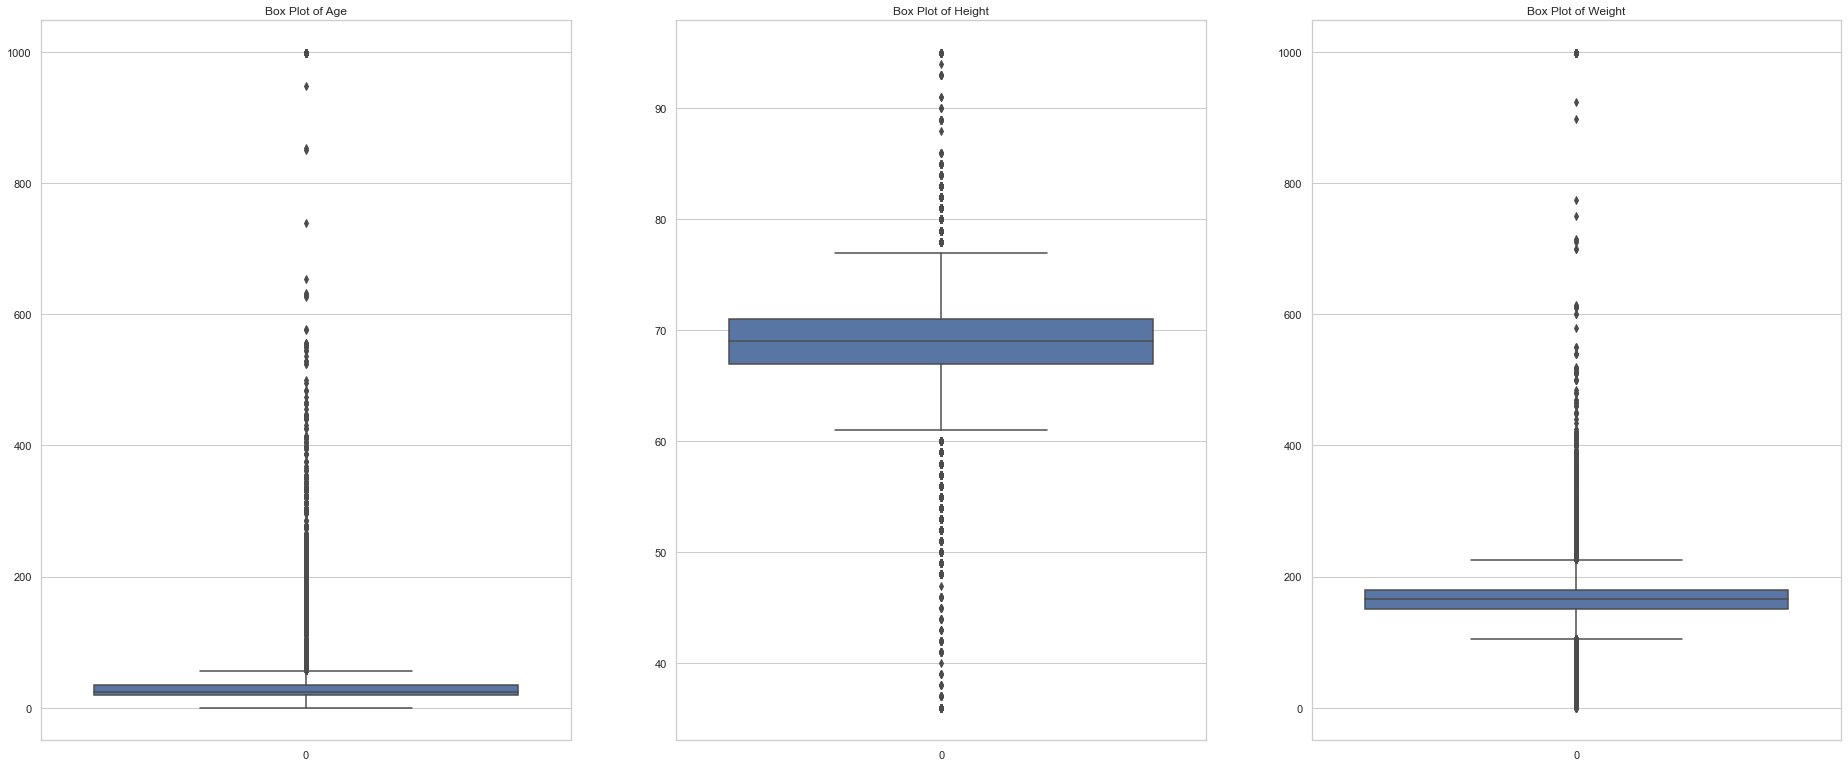

In [36]:
# Visualize distribution of ages, heights and weights using box plots
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(10, 10))
plt.subplot(131)
sns.boxplot(data=snf_data_exp.age)
#snf_data_exp.boxplot('age')
plt.title('Box Plot of Age')

plt.subplot(132)
sns.boxplot(data=snf_data_exp.height)
#snf_data_exp.boxplot('height')
plt.title('Box Plot of Height')

plt.subplot(133)
sns.boxplot(data=snf_data_exp.weight)
#snf_data_exp.boxplot('weight')
plt.title('Box Plot of Weight')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1, wspace=0.2, hspace=0.2)

In [37]:
# Calculate upper and lower bounds of age, height and weight
print("Upper and Lower bounds")
for col in ['age', 'height', 'weight']:
    q1, q3 = np.percentile(snf_data_exp[col], [25,75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    print(col, lower_bound, upper_bound)

Upper and Lower bounds
age -3.5 56.5
height 61.0 77.0
weight 105.0 225.0


There exists erroneuous data in the age, height and weight parameters. 

*   Oldest person in America is 114 years old - ages above 100 are likely erroneous. Average lifespan of an American is 76 years old. Ages that are too small (below 5 yrs) are likely noise too, as an infant wouldn't be stopped.
*   Tallest person in America is 7'8" (92 in) - any height above is erroneous. Heights that are too short (below 40 in) are assumed to be noise.
*   Average American weights are 159 to 191 lbs. Weights below 50 lbs and above 300 lbs are likely noise.



# Task 3

# Who is most affected by Stop and Frisk, and in what capacity are they affected?

From the bar chart above, it looks like males (M) are much more likely to be frisked than females (F), by more than 20 times. Women are also less likely to be frisked if stopped by an officer, whereas men are.

# When does Stop and Frisk happen the most?

Based on the histogram bars, the time of stop has a correlation with the likelihood of being frisked. Binning the time of stop into 12 bins would likely result in loss of information, as compared to 24 bins (but this is too many bins). Hence, I would leave them unbinned for now. It is also important to note that individuals are more likely frisked during the night (& midnight) than the day.

# Where in New York City do the stops occur?

In 2011, about 50% of individuals stopped by NYPD are black (B) or African American, followed by White-Hispanic (Q), White(W), etc. Most of the police stops occured in the city of Brooklyn (30%) followed by Queens (25%), Manhattan (20%) and Bronx (20%).

Individuals (stopped by police) who are black (B), white-hispanic (Q) and black-hispanic (P) are more likely to be frisked than not, with African-Americans being frisked the most. On the other hand, individuals who are white (W), asian (A) and american indian (I) are less likely to be frisked, with white individuals having the highest no-frisk to frisk ratio.

It looks like one is more likely to be frisked in most cities (if stopped) except in Staten Island. However, the discrepancy of no-frisk to frisk in Bronx and Queens is the greatest.  

In [ ]:
# Visualize frisks by hair color
sns.catplot(x='haircolr', hue='frisked', data=snf_data_exp, kind='count', palette='pastel', edgecolor='0.6')
plt.title('Frisks by hair color'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

Individuals with black hair (BK) and brown eyes (BR) are more likely to be frisked, but given there isn't too much gap between Y/N for all colors of hair and eyes, these attribute don't seem to be signifcant factors in predicting if someone gets frisked.

Individuals with medium (M) and thin (T) body builds are more likely to be frisked than heavy (H) or muscular (U) builds.

This chart is interesting as it tells us that an individual is 2.5 times more likely to be frisked if the officer is not in a uniform. On the other hand, there isn't too much difference if the officer is in uniform. This is contradictory to what we would expect.

## Feature Engineering
Some of the feature engineering like scaling needs to be done in the cross-validation loop, but some of the data may need to be engineered out on a global scale. These include removal of noise from data, conversion of categorical parameters into binary attributes, and sampling of dataset. 

### Remove noise from data (age, height & weight) found in exploration

In [38]:
# Create deep copy of processed dataset
snf_data_feat = snf_data_toclean.copy()
snf_data_feat.shape
#snf_data_feat.drop('frisked',axis='columns', inplace=True)

(638447, 25)

In [39]:
### Remove erroneous ages, heights and weights

# Remove rows with ages below 5 and above 100 years old 
snf_data_feat = snf_data_feat[(snf_data_feat['age']>=5) & (snf_data_feat['age']<=100)]

# Remove rows with heights below 40 in and above 90 in
snf_data_feat = snf_data_feat[(snf_data_feat['height']>=40) & (snf_data_feat['height']<=90)]

# Remove rows with weights below 50 lbs and above 300 lbs
snf_data_feat = snf_data_feat[(snf_data_feat['weight']>=50) & (snf_data_feat['weight']<=300)]

# Check if some rows were removed correctly 
snf_data_feat[['age','height','weight']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,634006.0,27.872288,11.670406,5.0,19.0,24.0,34.0,100.0
height,634006.0,68.570288,3.116178,40.0,67.0,69.0,71.0,90.0
weight,634006.0,168.677025,28.117731,50.0,150.0,165.0,180.0,300.0


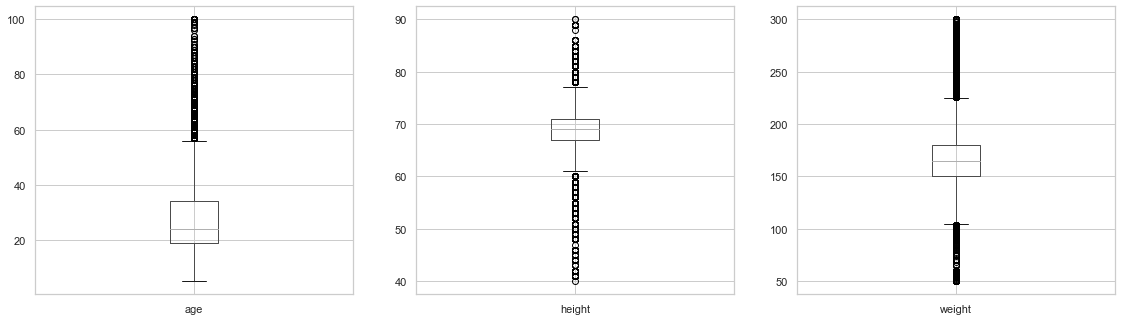

In [40]:
# Visualize distribution of ages, heights and weights
plt.subplot(131)
snf_data_feat.boxplot('age')
plt.subplot(132)
snf_data_feat.boxplot('height')
plt.subplot(133)
snf_data_feat.boxplot('weight')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1, wspace=0.2, hspace=0.2)

Although outliers still exist in these 3 attributes, I believe they're clean enough for us to proceed with analysis. Will consider revisiting if model accuracy needs to be improved.

### Convert categorical values into binary attributes using binarization or One Hot Encoding

This is done to eliminate any ordinal relationship or magnitude differences between nominal categorical data, thus improving model accuracy.

In [41]:
str_cols

Index(['sex', 'race', 'haircolr', 'eyecolor', 'build', 'city', 'inout',
       'trhsloc', 'typeofid', 'othpers', 'explnstp', 'offunif', 'ac_rept',
       'ac_proxm', 'ac_evasv', 'ac_assoc', 'ac_cgdir', 'ac_incid', 'ac_time',
       'ac_stsnd', 'arstmade'],
      dtype='object')

In [42]:
# View number of unique values for each cateogorical parameter
#str_cols.drop('frisked',axis='')
snf_data_feat[str_cols].nunique()

sex          2
race         6
haircolr     9
eyecolor    10
build        4
city         5
inout        2
trhsloc      3
typeofid     3
othpers      2
explnstp     2
offunif      2
ac_rept      2
ac_proxm     2
ac_evasv     2
ac_assoc     2
ac_cgdir     2
ac_incid     2
ac_time      2
ac_stsnd     2
arstmade     2
dtype: int64

In [43]:
### sex parameter 
# View unique values for sex parameter
print(snf_data_feat['sex'].value_counts())

# Convert sex parameter into binary
snf_data_feat['sex'] = snf_data_feat['sex'].replace({'M': 1, 'F': 0})

# Check if values converted correctly
print(snf_data_feat['sex'].value_counts())

M    590604
F     43402
Name: sex, dtype: int64
1    590604
0     43402
Name: sex, dtype: int64


In [44]:
### inout parameter
print(snf_data_feat['inout'].value_counts())

# Convert inout parameter into binary
snf_data_feat['inout'] = snf_data_feat['inout'].replace({'I': 1, 'O': 0})

# Check if values converted correctly
print(snf_data_feat['inout'].value_counts())

O    505557
I    128449
Name: inout, dtype: int64
0    505557
1    128449
Name: inout, dtype: int64


In [45]:
# Retrieve list of parameters with yes/no values
yesno_cols = str_cols[snf_data_feat[str_cols].nunique() == 2][1:]
yesno_cols

Index(['inout', 'othpers', 'explnstp', 'offunif', 'ac_rept', 'ac_proxm',
       'ac_evasv', 'ac_assoc', 'ac_cgdir', 'ac_incid', 'ac_time', 'ac_stsnd',
       'arstmade'],
      dtype='object')

In [46]:
### Yes/No parameter conversion
# View unique values for different yes/no parameters
snf_data_feat[yesno_cols].apply(pd.value_counts)

,inout,othpers,explnstp,offunif,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,arstmade
0,505557.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,128449.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N,NaN,496311.0,498.0,165791.0,562386.0,499349.0,511211.0,607732.0,478594.0,254841.0,366278.0,618596.0,595772.0
Y,NaN,137695.0,633508.0,468215.0,71620.0,134657.0,122795.0,26274.0,155412.0,379165.0,267728.0,15410.0,38234.0


In [47]:
# Convert Yes/No columns to integers (1/0)
snf_data_feat[yesno_cols] = snf_data_feat[yesno_cols].replace({'N':0, 'Y':1})

# Check if values converted correctly
snf_data_feat[yesno_cols].apply(pd.value_counts)

,inout,othpers,explnstp,offunif,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,arstmade
0,505557,496311,498,165791,562386,499349,511211,607732,478594,254841,366278,618596,595772
1,128449,137695,633508,468215,71620,134657,122795,26274,155412,379165,267728,15410,38234


In [48]:
# Retrieve list of parameters with more than 2 values
ohc_cols = str_cols[snf_data_feat[str_cols].nunique() > 2]
ohc_cols

Index(['race', 'haircolr', 'eyecolor', 'build', 'city', 'trhsloc', 'typeofid'], dtype='object')

In [49]:
#new
save_copy= snf_data_feat.copy()

In [50]:
 # Convert all categorical data into binary using One Hot Encoding
ohc_df = pd.get_dummies(snf_data_feat[ohc_cols])

# Concatenate One Hot Encoding dataframe with original dataframe and the label (frisked) as the last column
snf_data_feat = pd.concat([snf_data_feat.iloc[:,:-1], ohc_df, snf_data_feat.iloc[:,-1]], axis=1)

# Remove columns
snf_data_feat.drop(ohc_cols, axis=1, inplace=True)

snf_data_feat.head()

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,arstmade
0,1,21,68,182,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
1,1,15,66,140,5,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
3,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
4,1,20,75,185,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0


In [51]:
# Get list of columns which have binary values
binary_cols = snf_data_feat.columns[5:].insert(loc=0, item=snf_data_feat.columns[0])

# View number of values
snf_data_feat[binary_cols].apply(pd.value_counts)

,sex,inout,othpers,explnstp,offunif,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,arstmade
0,43402,505557,496311,498,165791,562386,499349,511211,607732,478594,...,506155,489974,607758,548489,131242,588281,287987,619389,360636,595772
1,590604,128449,137695,633508,468215,71620,134657,122795,26274,155412,...,127851,144032,26248,85517,502764,45725,346019,14617,273370,38234


In [52]:
# View distribution in mean and std dev of cleaned dataset
snf_data_feat.describe().iloc[:3]

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,arstmade
count,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,...,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000
mean,0.931543,27.872288,68.570288,168.677025,1438.010790,0.202599,0.217182,0.999215,0.738502,0.112964,...,0.201656,0.227178,0.041400,0.134884,0.792996,0.072121,0.545766,0.023055,0.431179,0.060305
std,0.252528,11.670406,3.116178,28.117731,727.729226,0.401936,0.412328,0.028015,0.439451,0.316549,...,0.401237,0.419009,0.199214,0.341599,0.405159,0.258688,0.497901,0.150078,0.495241,0.238052


### What are the most important factors contributing to a person getting frisked

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings                           # silence warnings that commonly occur with random forest
warnings.filterwarnings('ignore')

# Create deep copy for feature selection
snf_data_feat_selec = snf_data_feat.copy()

In [54]:
snf_data_feat_selec

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,arstmade
0,1,21,68,182,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
1,1,15,66,140,5,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
3,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
4,1,20,75,185,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685719,1,22,66,180,2355,0,0,1,1,0,...,0,1,0,0,1,0,1,0,0,0
685720,1,19,69,160,2358,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0
685721,1,20,69,200,2358,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0
685722,1,22,70,200,2358,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0


In [55]:
# Perform feature selection using random forest classifier
x = snf_data_feat_selec.iloc[:,:-1]
y = snf_data_feat_selec.iloc[:,-1]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

random_forest_feat = RandomForestClassifier(random_state = 50)   # instantiate the random forest  
random_forest_feat = random_forest_feat.fit(x,np.ravel(y_encoded)) # fit the random forest
importances = random_forest_feat.feature_importances_ # extract the expected feature importances
# std = np.std([tree.feature_importances_ for tree in random_forest_feat.estimators_],axis=0) # calculate stdev over trees
feat_ranks = np.argsort(importances)[::-1]   # find feature ranks in descending order

In [56]:
# Print feature ranking
print("Feature Ranking (The feature importance values sum to 1):")                 
for f in range(x.shape[1]):
    print("%d. %s (%.4f)" % (f + 1, x.columns.values[feat_ranks[f]], importances[feat_ranks[f]]))

Feature Ranking (The feature importance values sum to 1):
1. timestop (0.1989)
2. age (0.1517)
3. weight (0.1329)
4. height (0.1194)
5. ac_rept (0.0217)
6. othpers (0.0204)
7. ac_cgdir (0.0195)
8. ac_proxm (0.0185)
9. ac_time (0.0167)
10. race_B (0.0159)
11. build_M (0.0154)
12. race_Q (0.0148)
13. ac_evasv (0.0148)
14. offunif (0.0143)
15. build_T (0.0141)
16. ac_incid (0.0131)
17. haircolr_BK (0.0124)
18. haircolr_BR (0.0117)
19. inout (0.0111)
20. city_QUEENS (0.0095)
21. sex (0.0095)
22. city_MANHATTAN (0.0091)
23. city_BRONX (0.0090)
24. race_P (0.0089)
25. ac_assoc (0.0086)
26. race_W (0.0085)
27. eyecolor_BR (0.0084)
28. city_BROOKLYN (0.0078)
29. build_H (0.0077)
30. typeofid_P (0.0069)
31. eyecolor_BK (0.0068)
32. ac_stsnd (0.0063)
33. typeofid_V (0.0058)
34. trhsloc_H (0.0057)
35. race_A (0.0053)
36. trhsloc_P (0.0053)
37. city_STATEN IS (0.0049)
38. haircolr_BA (0.0040)
39. trhsloc_T (0.0034)
40. eyecolor_BL (0.0030)
41. haircolr_BL (0.0025)
42. eyecolor_HA (0.0024)
43. hair

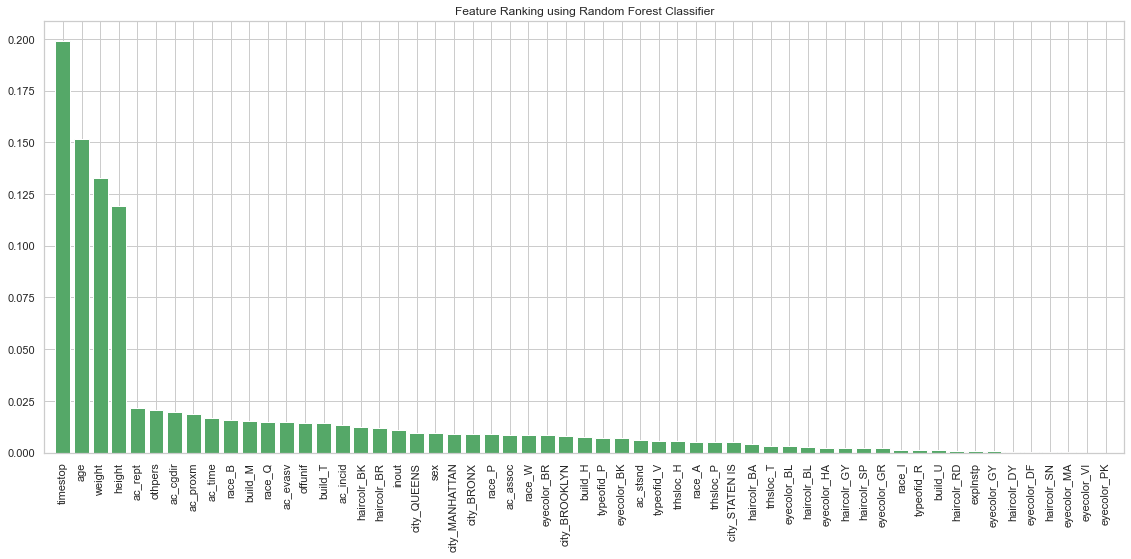

In [57]:
# Plot the feature importance   
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15, 6))
plt.title("Feature Ranking using Random Forest Classifier")
plt.bar(range(x.shape[1]), importances[feat_ranks], color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[feat_ranks], rotation=90)
plt.xlim([-1, x.shape[1]]); plt.ylim(0)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

We can see that there is a jump in the feature importance score after the 4th-ranked feature. We decided to keep the top 10 features and drop the rest of the features, as these constitute more than 70% of the total feature importances. 

In [58]:
# Create deep copy of dataframe before filtering
snf_data_filtered = snf_data_feat.copy()

In [59]:
# Filter out features to the top 10 most important ones
feat_to_filter = feat_ranks[10:]
print("Number of features to remove:", feat_to_filter.size)

# Drop filtered features
snf_data_filtered.drop(snf_data_feat.columns[feat_to_filter], axis = 1, inplace = True)

Number of features to remove: 47


In [60]:
# Check if columns removed
snf_data_filtered.head()

,age,height,weight,timestop,othpers,ac_rept,ac_proxm,ac_cgdir,ac_time,race_B,arstmade
0,21,68,182,0,0,0,0,0,1,0,0
1,15,66,140,5,0,0,0,0,0,1,0
2,17,67,130,7,1,0,1,1,1,1,0
3,17,67,130,7,1,0,1,1,1,1,0
4,20,75,185,7,1,0,1,1,1,1,0


### Perform data sampling due to large size of dataset

This is to ensure our models can be run in a reasonable amount of time, given the dataset size of more than 600,000 records. 

In [61]:
# Sample dataset using test train split to keep records that were not sampled 
snf_data_analysis, snf_data_unused = train_test_split(snf_data_filtered, train_size=100000, random_state=100)

# Display shapes of dataset
print("Analysis dataset =",snf_data_analysis.shape)
print("unused dataset =",snf_data_unused.shape)

Analysis dataset = (100000, 11)
unused dataset = (534006, 11)


In [62]:
# Compare % differences in mean and std dev between analysis and full dataset, to ensure representative dataset
analysis_dist = snf_data_analysis.describe().iloc[1:3]
full_dist =  snf_data_filtered.describe().iloc[1:3]
diff_dist = abs(analysis_dist - full_dist)/full_dist * 100   # compute percentage difference
diff_dist

,age,height,weight,timestop,othpers,ac_rept,ac_proxm,ac_cgdir,ac_time,race_B,arstmade
mean,0.148170,0.011124,0.067926,0.161121,0.222158,0.287021,0.093820,0.250067,0.198900,0.079715,0.539625
std,0.048711,0.266330,0.057051,0.366295,0.079941,0.124945,0.034664,0.084716,0.026485,0.004415,0.252490


Analysis dataset seems fairly representative of the full dataset - the difference in mean of the response feature (frisked) between the analysis dataset and the complete dataset is less than 0.2%.

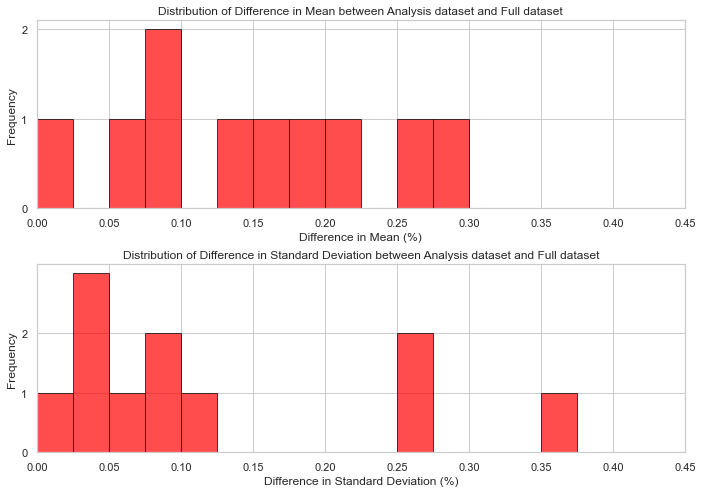

In [63]:
# Visualize % differences in mean and std dev between analysis and full dataset
plt.subplot(211)
diff_dist.loc['mean'].plot(kind='hist', bins=np.arange(0,0.45,0.025),color='red', alpha=0.7, edgecolor='black')
# plt.xticks(range(0,36,5)); 
plt.xlim([0,0.45]); plt.yticks([0,1,2])
plt.xlabel('Difference in Mean (%)'); plt.title('Distribution of Difference in Mean between Analysis dataset and Full dataset')
# plt.grid()

plt.subplot(212)
diff_dist.loc['std'].plot(kind='hist', bins=np.arange(0,0.45,0.025), color='red', alpha=0.7, edgecolor='black')
# plt.xticks(range(0,36,5)); 
plt.xlim([0,0.45]); plt.yticks([0,1,2])
plt.xlabel('Difference in Standard Deviation (%)'); plt.title('Distribution of Difference in Standard Deviation between Analysis dataset and Full dataset')
# plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.3)

From both these histograms, we can see that the analysis dataset is representative of the full dataset due to low differences in means and standard deviations.

In [64]:
# View analysis dataset
snf_data_analysis.describe().iloc[:3]

,age,height,weight,timestop,othpers,ac_rept,ac_proxm,ac_cgdir,ac_time,race_B,arstmade
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,27.83099,68.562660,168.562450,1440.327730,0.216700,0.112640,0.212590,0.245740,0.421440,0.528820,0.059980
std,11.67609,3.107879,28.133773,725.063588,0.411999,0.316154,0.409142,0.430527,0.493792,0.499171,0.237451


In [65]:
# View unused dataset
snf_data_unused.describe().iloc[:3]

,age,height,weight,timestop,othpers,ac_rept,ac_proxm,ac_cgdir,ac_time,race_B,arstmade
count,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000
mean,27.880022,68.571716,168.698481,1437.576911,0.217273,0.113025,0.212353,0.245012,0.422437,0.528320,0.060366
std,11.669336,3.117731,28.114701,728.227176,0.412390,0.316624,0.408974,0.430095,0.493948,0.499198,0.238165


Moving forward, the analysis dataset (10 predictor features, 1 response feature) will be used for data modelling and analysis. The unused dataset can be used as additional testing data, if necessary.

## Data Analysis

In [66]:
snf_data_knn = snf_data_analysis.copy()
snf_data_knn

,age,height,weight,timestop,othpers,ac_rept,ac_proxm,ac_cgdir,ac_time,race_B,arstmade
669596,27,69,160,905,0,0,0,0,0,1,0
265666,27,68,185,1510,1,0,0,0,0,1,0
215186,29,70,170,2239,0,0,0,0,0,0,0
614763,33,66,165,5,0,1,0,0,0,1,0
188696,46,70,220,1133,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
373582,20,66,160,1513,0,1,0,0,0,0,0
230861,16,67,150,2155,0,1,1,0,0,0,0
71369,20,66,170,2100,0,0,0,0,1,0,1
228537,14,69,150,2100,0,0,0,0,0,1,0


array([<AxesSubplot:ylabel='arstmade'>], dtype=object)

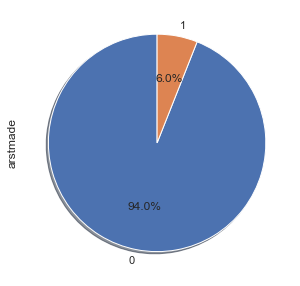

In [186]:
snf_data_knn['arstmade'].value_counts().plot(kind='pie', subplots=True, shadow = True,startangle=90,
figsize=(8,5), autopct='%1.1f%%')

Text(0.5, 1.0, 'Distribution in Target Variable ')

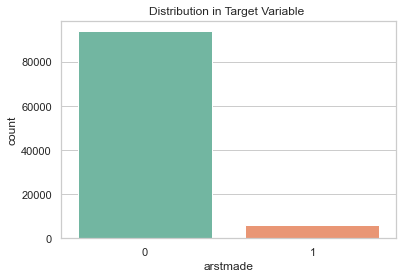

In [187]:
#checking the data distribution in target column
sns.set(style='whitegrid')
sns.countplot(snf_data_knn['arstmade'], palette='Set2')
plt.title("Distribution in Target Variable ")

In [188]:
#Separating the dependent and independent variables
y =snf_data_knn['arstmade']
X =snf_data_knn.drop(['arstmade'],axis=1)

In [189]:
count_class_0, count_class_1 = y.value_counts()
count_class_0, count_class_1

(94002, 5998)

In [190]:
df_class_0 = snf_data_knn[snf_data_knn['arstmade'] == 0]
df_class_1 = snf_data_knn[snf_data_knn['arstmade'] == 1]

In [191]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

Random under-sampling:
1    5998
0    5998
Name: arstmade, dtype: int64


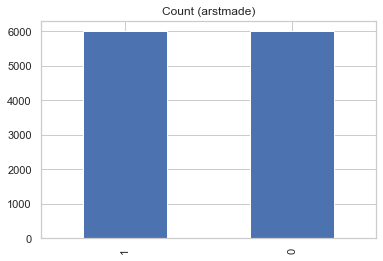

In [192]:
print('Random under-sampling:')
print(df_test_under.arstmade.value_counts())

df_test_under.arstmade.value_counts().plot(kind='bar', title='Count (arstmade)');

In [193]:
df_test_under.head()

,age,height,weight,timestop,othpers,ac_rept,ac_proxm,ac_cgdir,ac_time,race_B,arstmade
36234,26,69,270,2010,0,0,1,0,0,1,0
45144,44,65,200,903,0,0,0,0,1,0,0
263229,26,68,150,1313,0,0,0,0,1,1,0
78974,32,70,200,1800,1,0,1,0,1,1,0
588404,13,66,135,1710,1,0,0,0,0,0,0


In [194]:
data_Y = df_test_under['arstmade']
data_X = df_test_under.drop('arstmade', axis=1)

In [195]:
X=data_X
y=data_Y

In [196]:
#dividing data_set into train & test
from sklearn.model_selection import train_test_split
X_trainB, X_testB, Y_trainB, Y_testB= train_test_split(X, y, test_size=0.2, random_state=82)

In [197]:
print(X_trainB.shape, X_testB.shape, Y_trainB.shape, Y_testB.shape)

(9596, 10) (2400, 10) (9596,) (2400,)


In [198]:
X_res, Y_res = X_trainB.copy(),Y_trainB.copy()

In [199]:
X_res.shape,Y_res.shape

((9596, 10), (9596,))

In [200]:
YES = Y_res==1

NO  = Y_res==0

In [201]:
yes=len(YES)
no=len(NO)

In [202]:
#importing packages 
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier


from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import plot_confusion_matrix

In [203]:
# group of list to build Datframe of results
accuracy=[]
Precision=[]
Recall_score=[]
Specificity_list=[]
True_pve=[]
True_nve=[]
False_nve=[]
False_pve=[]
F1_Score=[]
F2_Score=[]
AUC=[]
k_list=[]
models_name=['ExtraTreesClassifier','LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier','GaussianNB','BaggingClassifier','AdaBoostClassifier'
            ,'RandomForestClassifier','QuadraticDiscriminantAnalysis','VotingClassifier(DTC)']#,'SVC(linear)','SVC(rbf)']

In [204]:
models = list()
models.append(ExtraTreesClassifier())
models.append(LogisticRegression())
models.append(KNeighborsClassifier())
models.append(DecisionTreeClassifier())
models.append(GaussianNB())
models.append(BaggingClassifier())
models.append(AdaBoostClassifier())
models.append(RandomForestClassifier())
models.append(QuadraticDiscriminantAnalysis())
estimator = [] 
estimator.append(('DTC', DecisionTreeClassifier())) 
  
models.append(VotingClassifier(estimator,voting='soft'))

#models.append(SVC(C=1.0,kernel='sigmoid',degree=2, gamma=4,probability=True))
#models.append(SVC(probability=True,kernel='linear'))
#models.append(SVC(C=1.0,kernel='rbf',degree=1, gamma=0.7,probability=True))

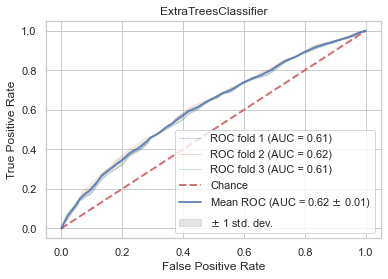

Recall score: 61.00625580685869 %
Specificity: 55.89656394394888 %
False +ve: 44.10343605605112 %
False -ve: 61.00625580685869 %
accuracy_score 0.584056366162932


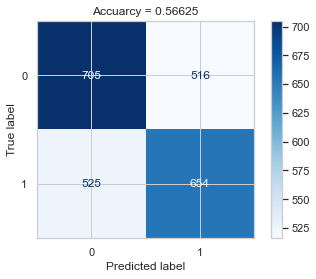

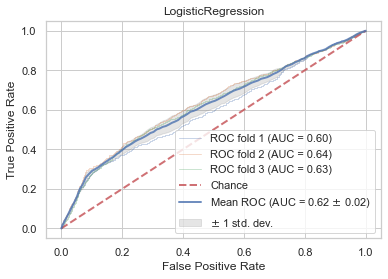

Recall score: 83.27299330511703 %
Specificity: 35.43696580536125 %
False +ve: 64.56303419463876 %
False -ve: 83.27299330511703 %
accuracy_score 0.5930895721151063


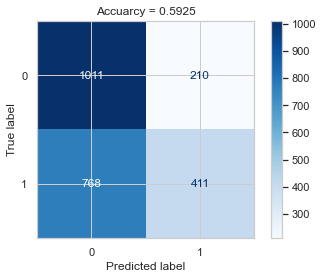

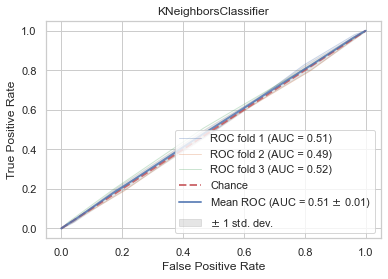

Recall score: 50.837642648705504 %
Specificity: 50.35817199117984 %
False +ve: 49.64182800882017 %
False -ve: 50.837642648705504 %
accuracy_score 0.5057328759191709


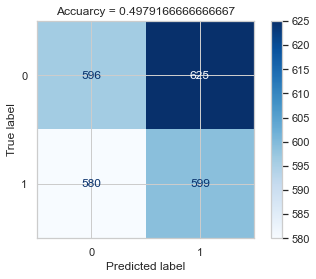

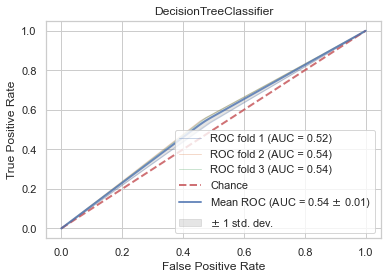

Recall score: 52.6759717098935 %
Specificity: 54.50732333369044 %
False +ve: 45.49267666630957 %
False -ve: 52.6759717098935 %
accuracy_score 0.5361260385907012


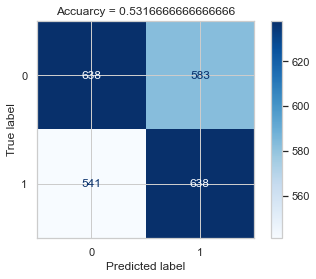

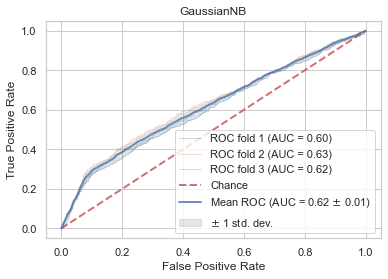

Recall score: 86.0431965990429 %
Specificity: 32.454433052061155 %
False +ve: 67.54556694793885 %
False -ve: 86.0431965990429 %
accuracy_score 0.592395851427248


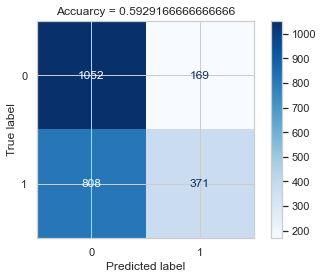

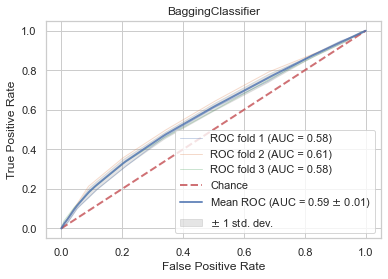

Recall score: 65.99200757754751 %
Specificity: 47.28304237433539 %
False +ve: 52.71695762566461 %
False -ve: 65.99200757754751 %
accuracy_score 0.5659961966591397


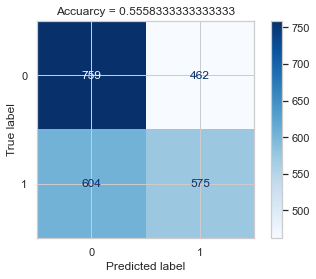

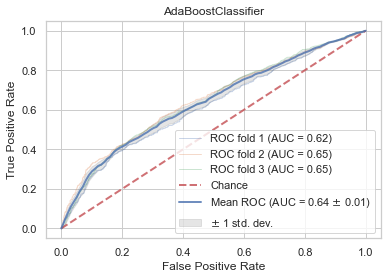

Recall score: 75.45533223516956 %
Specificity: 45.34804311770744 %
False +ve: 54.65195688229256 %
False -ve: 75.45533223516956 %
accuracy_score 0.603336698801459


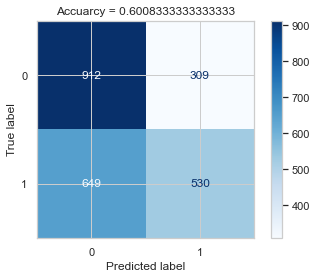

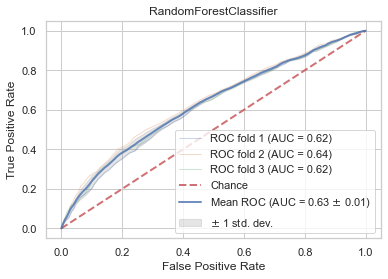

Recall score: 62.92144637076726 %
Specificity: 55.54502927599683 %
False +ve: 44.45497072400317 %
False -ve: 62.92144637076726 %
accuracy_score 0.591873480111169


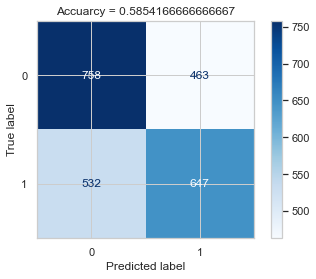

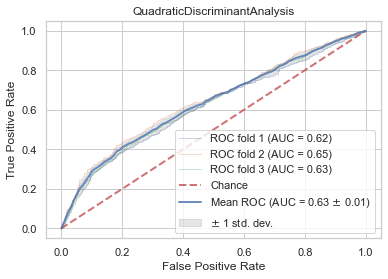

Recall score: 84.89102373654741 %
Specificity: 34.53705108274439 %
False +ve: 65.46294891725562 %
False -ve: 84.89102373654741 %
accuracy_score 0.5970846180012739


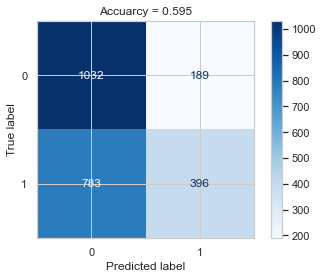

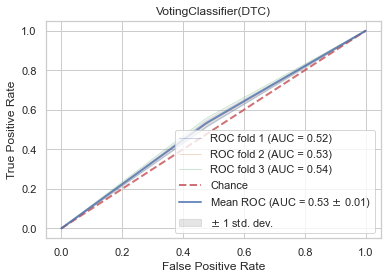

Recall score: 52.24820448526998 %
Specificity: 53.406498888534806 %
False +ve: 46.593501111465194 %
False -ve: 52.24820448526998 %
accuracy_score 0.5284838023276012


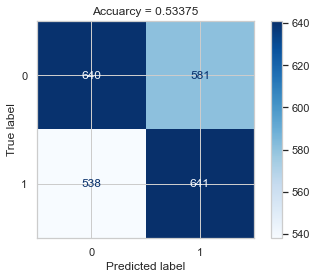

In [205]:
i=0
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
cv=KFold(5)
for model in models:
    temp_accuracy=[]
    temp_Precision=[]
    temp_Recall_score=[]
    temp_Specificity_list=[]
    temp_True_pve=[]
    temp_True_nve=[]
    temp_False_nve=[]
    temp_False_pve=[]
    temp_F1_Score=[]
    temp_F2_Score=[]
    temp_AUC=[]
    list_ns_fpr,list_ns_tpr,list_lr_fpr,list_lr_tpr= [],[],[],[]
    c=0
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots()
    if i==10:
        print('##########################################33')
        #X=X.loc[:, f_importances[f_importances>0.005].index]
        #X=X.loc[:, f_importances[:20].index]
        X_trainB, X_testB, Y_trainB, Y_testB= train_test_split(X, y, test_size=0.8, random_state=82)
        X_res, Y_res = X_trainB.copy(),Y_trainB.copy()
        yes=len(Y_res==1)
        no=len(Y_res==0)
        
        
    for train_index,test_index in cv.split(X_res):
        if c==3:
            break
        X_train,Y_train=X_res.iloc[train_index],Y_res.iloc[train_index]
        X_test,Y_test=X_res.iloc[test_index],Y_res.iloc[test_index]
        selectM=model.fit(X_train,Y_train)
        pred = model.predict(X_test)
        CM =pd.crosstab(Y_test,pred)
        #CM= confusion_matrix(Y_test, model.predict(X_test))
        #let us save TP, TN, FP, FN
        #try:
        TP = CM.iloc[0,0]
        FP = CM.iloc[1,0]
        TN = CM.iloc[1,1]
        FN = CM.iloc[0,1]

        #check recall of the model
        recall = ((TP)/(TP+FN))*100
        specificity = ((TN)/(TN+FP))*100
        false_positive = ((FP)/(FP+TN))*100
        false_neg = ((TP)/(FN+TP))*100
        F2_Measure = (5 * ((TP)/(TP+FP)) * recall) / (4 * ((TP)/(TP+FP)) + recall)

        temp_accuracy.append((TP+TN)/(TP+TN+FP+FN))
        temp_Precision.append((TP)/(TP+FP))
        temp_Recall_score.append(recall)
        temp_Specificity_list.append(specificity)
        temp_False_nve.append(false_neg)
        temp_False_pve.append(false_positive)
        temp_F1_Score.append((2*TP)/(2*TP+FP+FN))
        temp_F2_Score.append(F2_Measure)
        temp_True_pve.append(TP)
        temp_True_nve.append(TN)
        #except:
         #   print('  ')
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(Y_test))]

        # predict probabilities

        lr_probs = model.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]

        # calculate scores
        try:
            ns_auc = roc_auc_score(Y_test, ns_probs)
            lr_auc = roc_auc_score(Y_test, lr_probs)
            # calculate roc curves
            ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
            lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
            temp_AUC.append(lr_auc)
            list_ns_fpr.append(ns_fpr)
            list_ns_tpr.append(ns_tpr)
            list_lr_fpr.append(lr_fpr)
            list_lr_tpr.append(lr_tpr)
        except:
            print('')
        c=c+1
        
        viz = plot_roc_curve(model, X_res.iloc[test_index],Y_res.iloc[test_index],
                         name='ROC fold {}'.format(c),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=models_name[i])
    ax.legend(loc="lower right")
    plt.show()
    p1=((yes/len(X_res))*((mean(temp_True_pve)+mean(temp_False_pve))/len(X_res)))
    p2=((no/len(X_res))*((mean(temp_True_nve)+mean(temp_False_nve))/len(X_res)))
    p=p1+p2
    k=(mean(temp_accuracy)-p)/(1-p)
    print('Recall score: {} %'.format(mean(temp_Recall_score)))
    print('Specificity: {} %'.format(mean(temp_Specificity_list)))
    print('False +ve: {} %'.format(mean(temp_False_pve)))
    print('False -ve: {} %'.format(mean(temp_False_nve)))
    print('accuracy_score',mean(temp_accuracy))
    model_fit=model.fit(X_trainB,Y_trainB)
    plot_confusion_matrix(model_fit, X_testB, Y_testB,cmap=plt.cm.Blues)
    plt.title('Accuarcy = '+str(accuracy_score(Y_testB, model_fit.predict(X_testB))))
                                 #display_labels=Y_trainB,
                                 #cmap=plt.cm.Blues)
                                 #normalize=normalize)
    plt.show()
    
    #pyplot.errorbar(3, means, yerr=[mins, maxs], fmt='o')
    
    accuracy.append(mean(temp_accuracy))
    Precision.append(mean(temp_Precision))
    Recall_score.append(mean(temp_Recall_score))
    Specificity_list.append(mean(temp_Specificity_list))
    False_nve.append(mean(temp_False_nve))
    False_pve.append(mean(temp_False_pve))
    F1_Score.append(mean(temp_F1_Score))
    F2_Score.append(mean(temp_F2_Score))
    AUC.append(mean_auc)
    k_list.append(k)                                                                         
                                                                            
    #print('Precision',mean)
    #print('F1-Score',mean)
    i=i+1


In [207]:
arr=np.array([accuracy,Precision,Recall_score,Specificity_list,False_nve,False_pve,F1_Score,AUC,k_list]).transpose()
df=pd.DataFrame(arr,index=models_name
                ,columns=['accuracy','Precision','Recall_score','Specificity_list','True_pve Rate','False_pve Rate','F1_Score','AUC','Cohen’s Kappa'])
df

,accuracy,Precision,Recall_score,Specificity_list,True_pve Rate,False_pve Rate,F1_Score,AUC,Cohen’s Kappa
ExtraTreesClassifier,0.584056,0.580245,61.006256,55.896564,61.006256,44.103436,0.594355,0.616113,0.523125
LogisticRegression,0.593090,0.563055,83.272993,35.436966,83.272993,64.563034,0.671497,0.619467,0.530109
KNeighborsClassifier,0.505733,0.505656,50.837643,50.358172,50.837643,49.641828,0.506720,0.507271,0.443628
DecisionTreeClassifier,0.536126,0.536325,52.675972,54.507323,52.675972,45.492677,0.531456,0.535914,0.474386
GaussianNB,0.592396,0.559939,86.043197,32.454433,86.043197,67.545567,0.678263,0.617728,0.529058
BaggingClassifier,0.565996,0.555751,65.992008,47.283042,65.992008,52.716958,0.603043,0.586482,0.503668
AdaBoostClassifier,0.603337,0.579717,75.455332,45.348043,75.455332,54.651957,0.655146,0.638975,0.541836
RandomForestClassifier,0.591873,0.585828,62.921446,55.545029,62.921446,44.454971,0.606327,0.627738,0.531120
QuadraticDiscriminantAnalysis,0.597085,0.564303,84.891024,34.537051,84.891024,65.462949,0.677823,0.631413,0.534152
VotingClassifier(DTC),0.528484,0.528528,52.248204,53.406499,52.248204,46.593501,0.525435,0.528273,0.466608
